In [1]:
import numpy as np
import tensorflow as tf
from utility import *
import matplotlib.pyplot as plt
from matplotlib import colors
import os
%load_ext autoreload
%autoreload 2
%pylab inline

/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
halfSize=9
fullSize = 2*halfSize+1
X_orig, y_orig, cache = loadData(halfSize=halfSize, root="./", log_convert=False)

Starting to load data...
Cropping to mininmum size ...
n = 495 ; m = 495
Cropping to mininmum size ...
n = 486 ; m = 486
Cropping to mininmum size ...
n = 396 ; m = 396
Cropping to mininmum size ...
n = 383 ; m = 383
Cropping to mininmum size ...
n = 362 ; m = 362
Cropping to mininmum size ...
n = 342 ; m = 342
Cropping to mininmum size ...
n = 318 ; m = 318
Cropping to mininmum size ...
n = 293 ; m = 293
Cropping to mininmum size ...
n = 281 ; m = 281
Cropping to mininmum size ...
n = 271 ; m = 271
Cropping to mininmum size ...
n = 269 ; m = 269
Cropping to mininmum size ...
n = 265 ; m = 265
Cropping to mininmum size ...
n = 229 ; m = 229
Cropping to mininmum size ...
n = 213 ; m = 213
Cropping to mininmum size ...
n = 201 ; m = 201
Cropping to mininmum size ...
n = 178 ; m = 178
Cropping to mininmum size ...
n = 158 ; m = 158
Cropping to mininmum size ...
n = 153 ; m = 153
Cropping to mininmum size ...
n = 119 ; m = 119
Cropping to mininmum size ...
n = 125 ; m = 125
Cropping to min

In [3]:
myCache, nss_low, nss_high = cache
indices = []
sum = 0
for i in range(1, 24):
    n1 = nss_low[i, 1]
    n2 = nss_high[i, 1]
    n = np.min([n1, n2])
    sum += (n - 2*halfSize) **2
    indices.append(sum)
    print("chromosome %2d -> %d"%(i, sum))

chromosome  1 -> 227529
chromosome  2 -> 446553
chromosome  3 -> 589437
chromosome  4 -> 722662
chromosome  5 -> 840998
chromosome  6 -> 945974
chromosome  7 -> 1035974
chromosome  8 -> 1111599
chromosome  9 -> 1180768
chromosome 10 -> 1244777
chromosome 11 -> 1307778
chromosome 12 -> 1368787
chromosome 13 -> 1413308
chromosome 14 -> 1451333
chromosome 15 -> 1484822
chromosome 16 -> 1510422
chromosome 17 -> 1530022
chromosome 18 -> 1548247
chromosome 19 -> 1558448
chromosome 20 -> 1569897
chromosome 21 -> 1575673
chromosome 22 -> 1582397
chromosome 23 -> 1667661


In [4]:
print(X_orig.shape)
totalSize = indices[4]
trainSize = indices[3] #up until chromosome 3 
X_train = X_orig[:trainSize]
y_train = y_orig[:trainSize]
X_val = X_orig[trainSize:totalSize]
y_val = y_orig[trainSize:totalSize]
print("Trainging Size: ", X_train.shape)
print("Validation Size: ", X_val.shape)

(1667661, 19, 19, 1)
Trainging Size:  (722662, 19, 19, 1)
Validation Size:  (118336, 19, 19, 1)


In [20]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, fullSize, fullSize, 1])
y = tf.placeholder(tf.float32, [None])
is_training = tf.placeholder(tf.bool)

def myModel(X, y):
    firstLayerFilterSize = 9
    firstLayerNumFilters = 23
    secondLayerFilterSize = 8
    secondLayerNumFilters = 23
    Wconv1 = tf.get_variable("Wconv1", shape=[firstLayerFilterSize, firstLayerFilterSize, 1, firstLayerNumFilters])
    bconv1 = tf.get_variable("bconv1", shape=[firstLayerNumFilters])
    Wconv2 = tf.get_variable("Wconv2", shape=[secondLayerFilterSize, secondLayerFilterSize, firstLayerNumFilters, secondLayerNumFilters])
    bconv2 = tf.get_variable("bconv2", shape=[secondLayerNumFilters])
    shapeAfterConvs = fullSize - firstLayerFilterSize - secondLayerFilterSize + 2
    W1 = tf.get_variable("W1", shape=[shapeAfterConvs * shapeAfterConvs * secondLayerNumFilters, 1024])
    b1 = tf.get_variable("b1", shape=[1024])
    W2 = tf.get_variable("W2", shape=[1024, 1])
    b2 = tf.get_variable("b2", shape=[1])
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding="VALID") + bconv1
    h1 = tf.nn.relu(a1)
    a2 = tf.nn.conv2d(h1, Wconv2, strides=[1, 1, 1, 1], padding="VALID") + bconv2
    h2 = tf.nn.relu(a2)
    h2_flat = tf.reshape(h2, [-1, shapeAfterConvs * shapeAfterConvs * 23])
    a3 = tf.matmul(h2_flat, W1) + b1
    h3 = tf.nn.relu(a3)
    y_out = tf.matmul(h3, W2) + b2
    y_out = tf.reshape(y_out, [-1])
    return y_out

y_out = myModel(X, y)

diff = y - y_out
total_loss = tf.losses.mean_squared_error(y, y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(5e-1)
train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 17.6
Iteration 100: with minibatch training loss = 9.26e+05
Iteration 200: with minibatch training loss = 10.9
Iteration 300: with minibatch training loss = 3.2e+03
Iteration 400: with minibatch training loss = 3.27e+04
Iteration 500: with minibatch training loss = 1.67e+03
Iteration 600: with minibatch training loss = 4.53e+04
Iteration 700: with minibatch training loss = 1.44e+05
Iteration 800: with minibatch training loss = 9.13e+04
Iteration 900: with minibatch training loss = 2.71e+03
Iteration 1000: with minibatch training loss = 321
Iteration 1100: with minibatch training loss = 4.93e+03
Iteration 1200: with minibatch training loss = 3.1e+03
Iteration 1300: with minibatch training loss = 422
Iteration 1400: with minibatch training loss = 3.93e+03
Iteration 1500: with minibatch training loss = 382
Iteration 1600: with minibatch training loss = 4.98e+03
Iteration 1700: with minibatch training loss = 1.07e+03
Iteration 1800: with

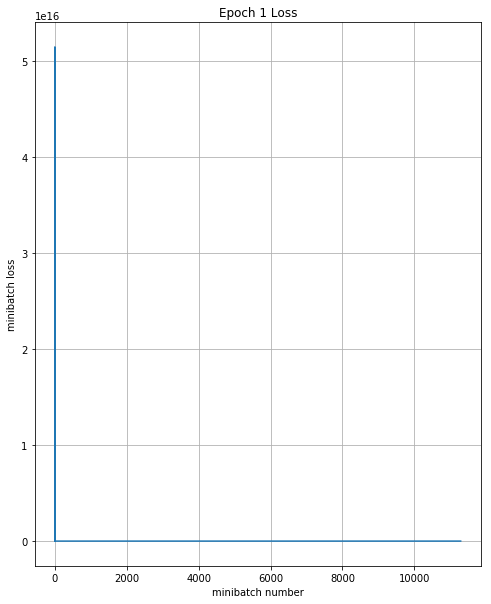

Iteration 11300: with minibatch training loss = 15.1
Iteration 11400: with minibatch training loss = 0.212
Iteration 11500: with minibatch training loss = 2.53
Iteration 11600: with minibatch training loss = 0.491
Iteration 11700: with minibatch training loss = 65.4
Iteration 11800: with minibatch training loss = 2
Iteration 11900: with minibatch training loss = 2.3
Iteration 12000: with minibatch training loss = 2.27
Iteration 12100: with minibatch training loss = 23.1
Iteration 12200: with minibatch training loss = 5.9
Iteration 12300: with minibatch training loss = 2.17
Iteration 12400: with minibatch training loss = 2.53
Iteration 12500: with minibatch training loss = 0.683
Iteration 12600: with minibatch training loss = 0.992
Iteration 12700: with minibatch training loss = 23.2
Iteration 12800: with minibatch training loss = 29
Iteration 12900: with minibatch training loss = 48.3
Iteration 13000: with minibatch training loss = 0.437
Iteration 13100: with minibatch training loss = 

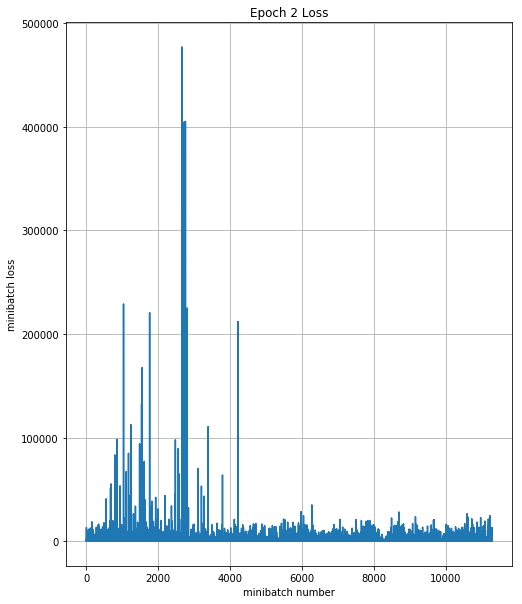

Iteration 22600: with minibatch training loss = 0.0366
Iteration 22700: with minibatch training loss = 12.7
Iteration 22800: with minibatch training loss = 0.412
Iteration 22900: with minibatch training loss = 4.15
Iteration 23000: with minibatch training loss = 4.23
Iteration 23100: with minibatch training loss = 17.7
Iteration 23200: with minibatch training loss = 5.51
Iteration 23300: with minibatch training loss = 35.4
Iteration 23400: with minibatch training loss = 0.0597
Iteration 23500: with minibatch training loss = 0.783
Iteration 23600: with minibatch training loss = 12.6
Iteration 23700: with minibatch training loss = 7.61
Iteration 23800: with minibatch training loss = 28
Iteration 23900: with minibatch training loss = 2.62
Iteration 24000: with minibatch training loss = 3.62
Iteration 24100: with minibatch training loss = 19
Iteration 24200: with minibatch training loss = 67.2
Iteration 24300: with minibatch training loss = 27.9
Iteration 24400: with minibatch training los

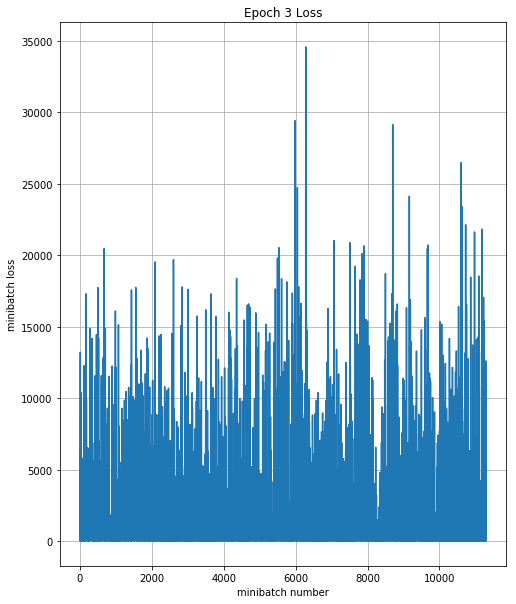

Iteration 33900: with minibatch training loss = 0.184
Iteration 34000: with minibatch training loss = 0.995
Iteration 34100: with minibatch training loss = 0.192
Iteration 34200: with minibatch training loss = 0.0229
Iteration 34300: with minibatch training loss = 3.45
Iteration 34400: with minibatch training loss = 13.3
Iteration 34500: with minibatch training loss = 133
Iteration 34600: with minibatch training loss = 1.37
Iteration 34700: with minibatch training loss = 0.0572
Iteration 34800: with minibatch training loss = 0.162
Iteration 34900: with minibatch training loss = 0.0161
Iteration 35000: with minibatch training loss = 0.0686
Iteration 35100: with minibatch training loss = 0.114
Iteration 35200: with minibatch training loss = 66.2
Iteration 35300: with minibatch training loss = 2.47
Iteration 35400: with minibatch training loss = 1.06
Iteration 35500: with minibatch training loss = 5.63
Iteration 35600: with minibatch training loss = 4.69
Iteration 35700: with minibatch tr

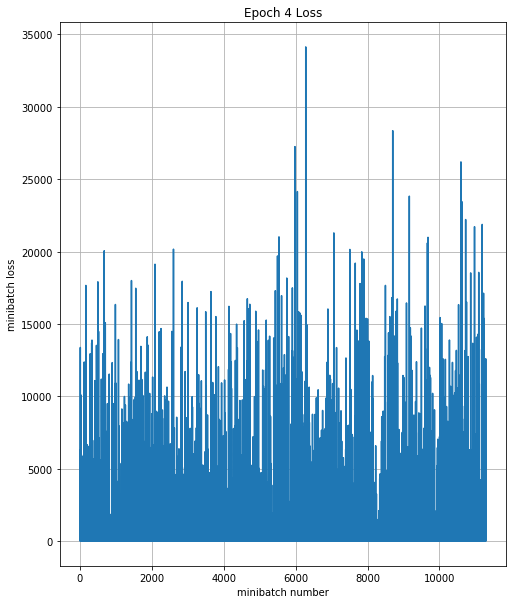

Iteration 45200: with minibatch training loss = 0.425
Iteration 45300: with minibatch training loss = 0.118
Iteration 45400: with minibatch training loss = 0.385
Iteration 45500: with minibatch training loss = 1.09
Iteration 45600: with minibatch training loss = 1.07
Iteration 45700: with minibatch training loss = 113
Iteration 45800: with minibatch training loss = 0.195
Iteration 45900: with minibatch training loss = 6.54
Iteration 46000: with minibatch training loss = 0.274
Iteration 46100: with minibatch training loss = 0.452
Iteration 46200: with minibatch training loss = 1.45
Iteration 46300: with minibatch training loss = 0.514
Iteration 46400: with minibatch training loss = 0.0674
Iteration 46500: with minibatch training loss = 1.28
Iteration 46600: with minibatch training loss = 281
Iteration 46700: with minibatch training loss = 0.582
Iteration 46800: with minibatch training loss = 0.338
Iteration 46900: with minibatch training loss = 7.99
Iteration 47000: with minibatch train

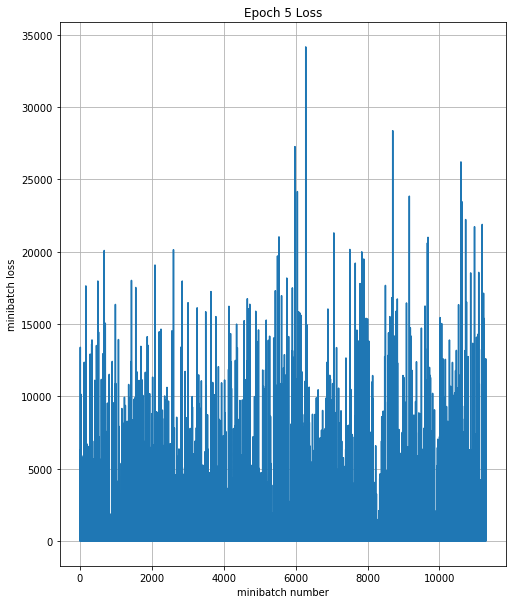

Iteration 56500: with minibatch training loss = 39.1
Iteration 56600: with minibatch training loss = 0.465
Iteration 56700: with minibatch training loss = 0.764
Iteration 56800: with minibatch training loss = 0.237
Iteration 56900: with minibatch training loss = 3.49
Iteration 57000: with minibatch training loss = 44.8
Iteration 57100: with minibatch training loss = 7.35
Iteration 57200: with minibatch training loss = 0.12
Iteration 57300: with minibatch training loss = 4.67
Iteration 57400: with minibatch training loss = 6.75
Iteration 57500: with minibatch training loss = 0.295
Iteration 57600: with minibatch training loss = 0.542
Iteration 57700: with minibatch training loss = 0.479
Iteration 57800: with minibatch training loss = 0.351
Iteration 57900: with minibatch training loss = 0.746
Iteration 58000: with minibatch training loss = 155
Iteration 58100: with minibatch training loss = 92.9
Iteration 58200: with minibatch training loss = 0.946
Iteration 58300: with minibatch traini

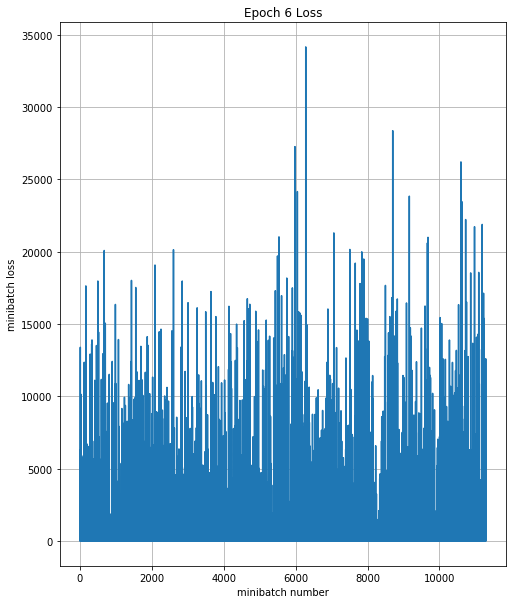

Iteration 67800: with minibatch training loss = 1.95
Iteration 67900: with minibatch training loss = 0.324
Iteration 68000: with minibatch training loss = 0.107
Iteration 68100: with minibatch training loss = 0.233
Iteration 68200: with minibatch training loss = 0.302
Iteration 68300: with minibatch training loss = 0.298
Iteration 68400: with minibatch training loss = 27.2
Iteration 68500: with minibatch training loss = 2.67
Iteration 68600: with minibatch training loss = 3.66
Iteration 68700: with minibatch training loss = 0.465
Iteration 68800: with minibatch training loss = 5.39
Iteration 68900: with minibatch training loss = 14.7
Iteration 69000: with minibatch training loss = 0.134
Iteration 69100: with minibatch training loss = 0.0711
Iteration 69200: with minibatch training loss = 0.0548
Iteration 69300: with minibatch training loss = 0.333
Iteration 69400: with minibatch training loss = 0.566
Iteration 69500: with minibatch training loss = 0.357
Iteration 69600: with minibatch 

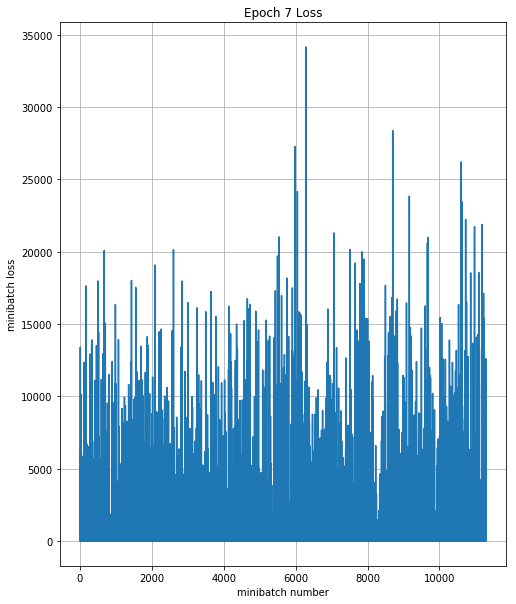

Iteration 79100: with minibatch training loss = 0.115
Iteration 79200: with minibatch training loss = 0.243
Iteration 79300: with minibatch training loss = 22.6
Iteration 79400: with minibatch training loss = 0.303
Iteration 79500: with minibatch training loss = 0.238
Iteration 79600: with minibatch training loss = 0.144
Iteration 79700: with minibatch training loss = 0.0399
Iteration 79800: with minibatch training loss = 12.5
Iteration 79900: with minibatch training loss = 0.0509
Iteration 80000: with minibatch training loss = 0.249
Iteration 80100: with minibatch training loss = 0.33
Iteration 80200: with minibatch training loss = 0.779
Iteration 80300: with minibatch training loss = 6.1
Iteration 80400: with minibatch training loss = 0.855
Iteration 80500: with minibatch training loss = 7.56
Iteration 80600: with minibatch training loss = 0.228
Iteration 80700: with minibatch training loss = 6.79
Iteration 80800: with minibatch training loss = 0.489
Iteration 80900: with minibatch t

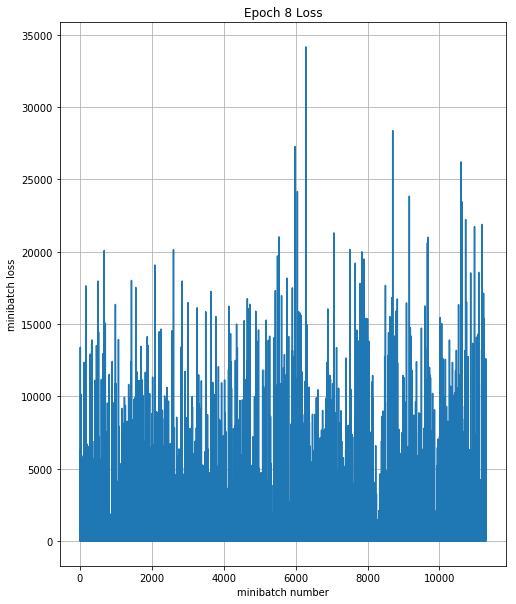

Iteration 90400: with minibatch training loss = 0.279
Iteration 90500: with minibatch training loss = 0.528
Iteration 90600: with minibatch training loss = 94.2
Iteration 90700: with minibatch training loss = 0.0772
Iteration 90800: with minibatch training loss = 0.68
Iteration 90900: with minibatch training loss = 0.0921
Iteration 91000: with minibatch training loss = 0.0547
Iteration 91100: with minibatch training loss = 149
Iteration 91200: with minibatch training loss = 6.23
Iteration 91300: with minibatch training loss = 0.8
Iteration 91400: with minibatch training loss = 15.5
Iteration 91500: with minibatch training loss = 143
Iteration 91600: with minibatch training loss = 0.485
Iteration 91700: with minibatch training loss = 0.102
Iteration 91800: with minibatch training loss = 0.144
Iteration 91900: with minibatch training loss = 0.619
Iteration 92000: with minibatch training loss = 1.33
Iteration 92100: with minibatch training loss = 0.189
Iteration 92200: with minibatch trai

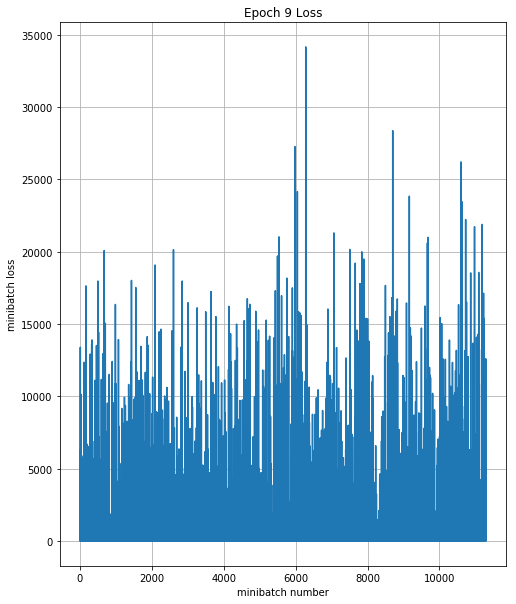

Iteration 101700: with minibatch training loss = 0.189
Iteration 101800: with minibatch training loss = 3.99
Iteration 101900: with minibatch training loss = 0.215
Iteration 102000: with minibatch training loss = 0.286
Iteration 102100: with minibatch training loss = 28.5
Iteration 102200: with minibatch training loss = 35
Iteration 102300: with minibatch training loss = 2.12
Iteration 102400: with minibatch training loss = 0.52
Iteration 102500: with minibatch training loss = 3.52
Iteration 102600: with minibatch training loss = 2.59
Iteration 102700: with minibatch training loss = 7.45
Iteration 102800: with minibatch training loss = 95.1
Iteration 102900: with minibatch training loss = 0.547
Iteration 103000: with minibatch training loss = 0.144
Iteration 103100: with minibatch training loss = 1.65
Iteration 103200: with minibatch training loss = 0.18
Iteration 103300: with minibatch training loss = 10.5
Iteration 103400: with minibatch training loss = 0.151
Iteration 103500: with m

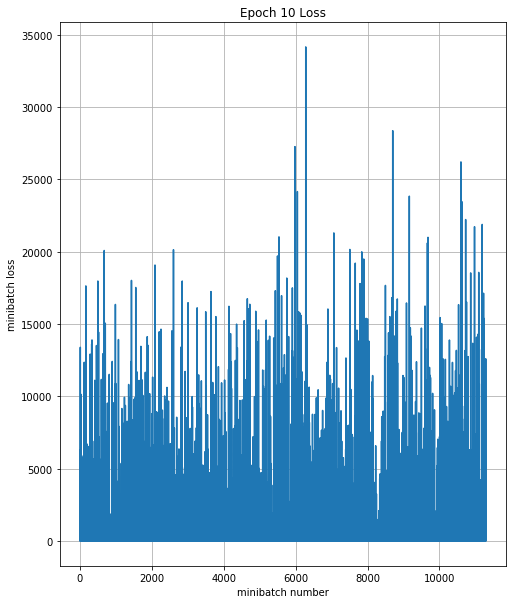

Iteration 113000: with minibatch training loss = 13.4
Iteration 113100: with minibatch training loss = 0.448
Iteration 113200: with minibatch training loss = 120
Iteration 113300: with minibatch training loss = 17.9
Iteration 113400: with minibatch training loss = 0.177
Iteration 113500: with minibatch training loss = 4.01
Iteration 113600: with minibatch training loss = 1.29
Iteration 113700: with minibatch training loss = 0.0731
Iteration 113800: with minibatch training loss = 0.195
Iteration 113900: with minibatch training loss = 1.91
Iteration 114000: with minibatch training loss = 0.175
Iteration 114100: with minibatch training loss = 0.481
Iteration 114200: with minibatch training loss = 128
Iteration 114300: with minibatch training loss = 0.366
Iteration 114400: with minibatch training loss = 16.1
Iteration 114500: with minibatch training loss = 1.18
Iteration 114600: with minibatch training loss = 0.257
Iteration 114700: with minibatch training loss = 0.228
Iteration 114800: wi

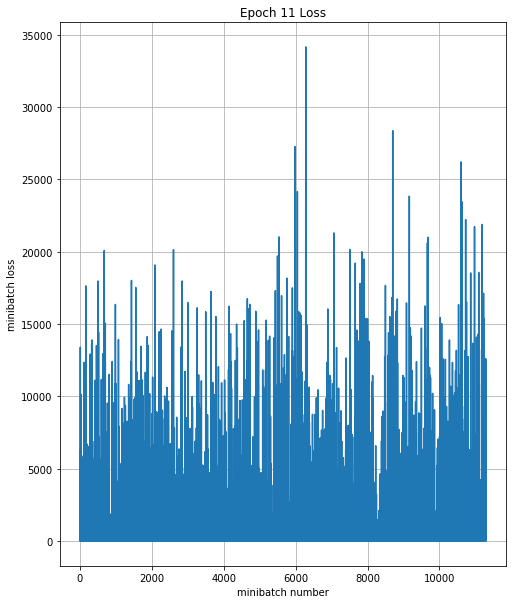

Iteration 124300: with minibatch training loss = 0.0581
Iteration 124400: with minibatch training loss = 0.447
Iteration 124500: with minibatch training loss = 93.4
Iteration 124600: with minibatch training loss = 0.166
Iteration 124700: with minibatch training loss = 73.3
Iteration 124800: with minibatch training loss = 0.847
Iteration 124900: with minibatch training loss = 1.18
Iteration 125000: with minibatch training loss = 2.47
Iteration 125100: with minibatch training loss = 3.86
Iteration 125200: with minibatch training loss = 1.41
Iteration 125300: with minibatch training loss = 124
Iteration 125400: with minibatch training loss = 1.19
Iteration 125500: with minibatch training loss = 1.01
Iteration 125600: with minibatch training loss = 1.61
Iteration 125700: with minibatch training loss = 0.174
Iteration 125800: with minibatch training loss = 0.627
Iteration 125900: with minibatch training loss = 12.8
Iteration 126000: with minibatch training loss = 0.605
Iteration 126100: wit

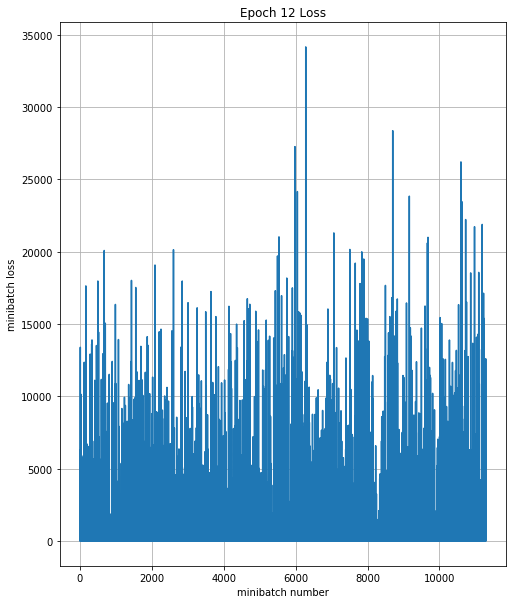

Iteration 135600: with minibatch training loss = 0.368
Iteration 135700: with minibatch training loss = 105
Iteration 135800: with minibatch training loss = 3.17
Iteration 135900: with minibatch training loss = 0.211
Iteration 136000: with minibatch training loss = 20.1
Iteration 136100: with minibatch training loss = 2.16
Iteration 136200: with minibatch training loss = 121
Iteration 136300: with minibatch training loss = 0.313
Iteration 136400: with minibatch training loss = 5.6
Iteration 136500: with minibatch training loss = 0.596
Iteration 136600: with minibatch training loss = 0.479
Iteration 136700: with minibatch training loss = 10.5
Iteration 136800: with minibatch training loss = 82.2
Iteration 136900: with minibatch training loss = 155
Iteration 137000: with minibatch training loss = 0.178
Iteration 137100: with minibatch training loss = 0.06
Iteration 137200: with minibatch training loss = 2.16
Iteration 137300: with minibatch training loss = 0.203
Iteration 137400: with mi

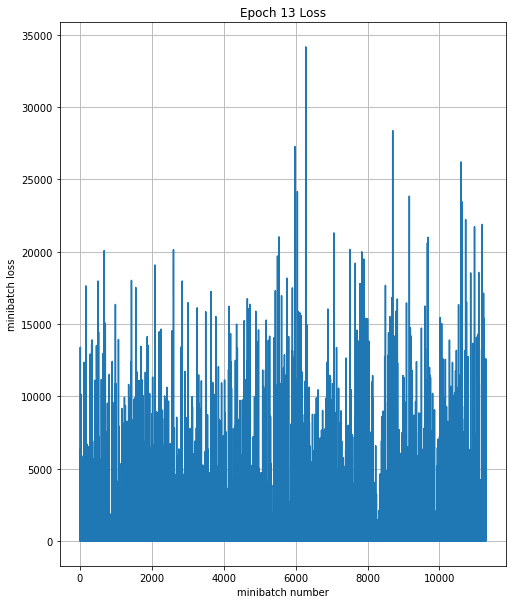

Iteration 146800: with minibatch training loss = 1.81
Iteration 146900: with minibatch training loss = 0.328
Iteration 147000: with minibatch training loss = 0.291
Iteration 147100: with minibatch training loss = 135
Iteration 147200: with minibatch training loss = 0.541
Iteration 147300: with minibatch training loss = 0.168
Iteration 147400: with minibatch training loss = 8.43
Iteration 147500: with minibatch training loss = 235
Iteration 147600: with minibatch training loss = 1.19
Iteration 147700: with minibatch training loss = 32.4
Iteration 147800: with minibatch training loss = 0.377
Iteration 147900: with minibatch training loss = 0.0394
Iteration 148000: with minibatch training loss = 17.5
Iteration 148100: with minibatch training loss = 0.42
Iteration 148200: with minibatch training loss = 0.493
Iteration 148300: with minibatch training loss = 0.49
Iteration 148400: with minibatch training loss = 6.79
Iteration 148500: with minibatch training loss = 0.444
Iteration 148600: wit

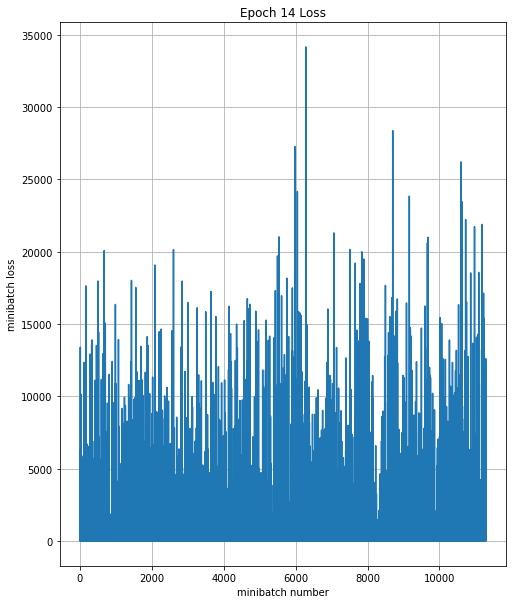

Iteration 158100: with minibatch training loss = 4.31
Iteration 158200: with minibatch training loss = 6.44
Iteration 158300: with minibatch training loss = 0.283
Iteration 158400: with minibatch training loss = 0.745
Iteration 158500: with minibatch training loss = 174
Iteration 158600: with minibatch training loss = 11.4
Iteration 158700: with minibatch training loss = 0.106
Iteration 158800: with minibatch training loss = 27.9
Iteration 158900: with minibatch training loss = 6.38
Iteration 159000: with minibatch training loss = 0.106
Iteration 159100: with minibatch training loss = 7.09
Iteration 159200: with minibatch training loss = 3.46
Iteration 159300: with minibatch training loss = 0.179
Iteration 159400: with minibatch training loss = 0.0516
Iteration 159500: with minibatch training loss = 0.62
Iteration 159600: with minibatch training loss = 0.309
Iteration 159700: with minibatch training loss = 0.541
Iteration 159800: with minibatch training loss = 0.0556
Iteration 159900: 

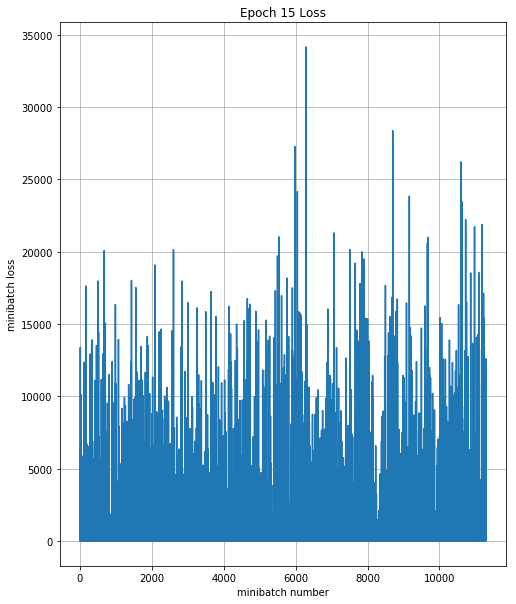

Iteration 169400: with minibatch training loss = 0.117
Iteration 169500: with minibatch training loss = 2.11
Iteration 169600: with minibatch training loss = 0.0473
Iteration 169700: with minibatch training loss = 0.11
Iteration 169800: with minibatch training loss = 48.8
Iteration 169900: with minibatch training loss = 12.1
Iteration 170000: with minibatch training loss = 0.288
Iteration 170100: with minibatch training loss = 2.68
Iteration 170200: with minibatch training loss = 0.275
Iteration 170300: with minibatch training loss = 6.11
Iteration 170400: with minibatch training loss = 1.34
Iteration 170500: with minibatch training loss = 6.03
Iteration 170600: with minibatch training loss = 0.417
Iteration 170700: with minibatch training loss = 16
Iteration 170800: with minibatch training loss = 0.42
Iteration 170900: with minibatch training loss = 0.164
Iteration 171000: with minibatch training loss = 33.4
Iteration 171100: with minibatch training loss = 0.264
Iteration 171200: with

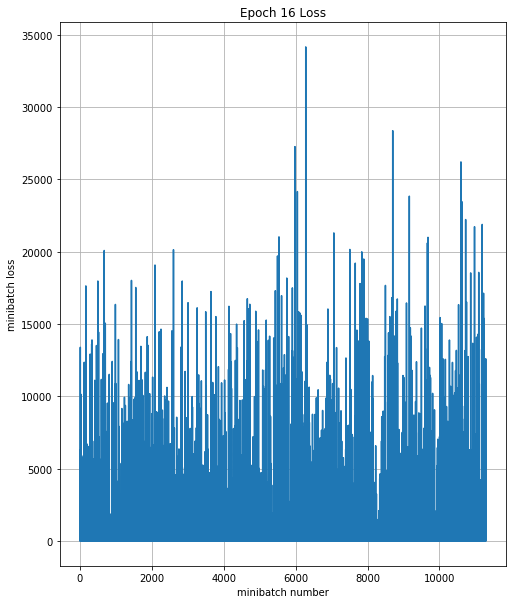

Iteration 180700: with minibatch training loss = 0.104
Iteration 180800: with minibatch training loss = 0.0693
Iteration 180900: with minibatch training loss = 0.168
Iteration 181000: with minibatch training loss = 0.85
Iteration 181100: with minibatch training loss = 0.0104
Iteration 181200: with minibatch training loss = 0.0256
Iteration 181300: with minibatch training loss = 0.265
Iteration 181400: with minibatch training loss = 1.55
Iteration 181500: with minibatch training loss = 0.687
Iteration 181600: with minibatch training loss = 105
Iteration 181700: with minibatch training loss = 0.16
Iteration 181800: with minibatch training loss = 0.44
Iteration 181900: with minibatch training loss = 0.395
Iteration 182000: with minibatch training loss = 0.0922
Iteration 182100: with minibatch training loss = 4.77
Iteration 182200: with minibatch training loss = 0.114
Iteration 182300: with minibatch training loss = 0.07
Iteration 182400: with minibatch training loss = 1.86
Iteration 18250

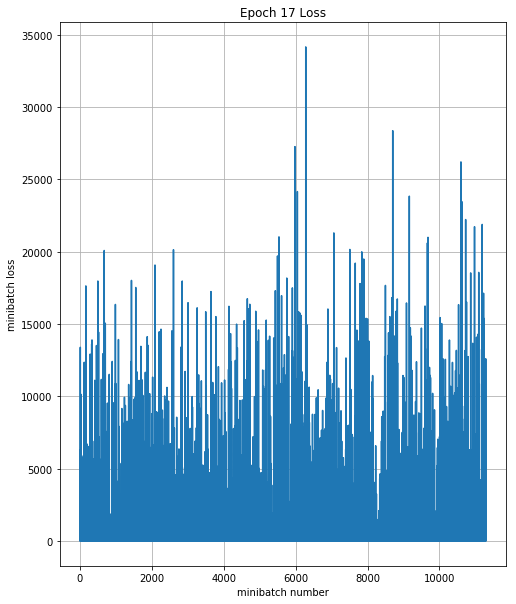

Iteration 192000: with minibatch training loss = 3.49
Iteration 192100: with minibatch training loss = 2.68
Iteration 192200: with minibatch training loss = 1.46
Iteration 192300: with minibatch training loss = 0.366
Iteration 192400: with minibatch training loss = 0.166
Iteration 192500: with minibatch training loss = 6.73
Iteration 192600: with minibatch training loss = 15.2
Iteration 192700: with minibatch training loss = 0.216
Iteration 192800: with minibatch training loss = 0.452
Iteration 192900: with minibatch training loss = 149
Iteration 193000: with minibatch training loss = 5.05
Iteration 193100: with minibatch training loss = 3.53
Iteration 193200: with minibatch training loss = 0.743
Iteration 193300: with minibatch training loss = 0.103
Iteration 193400: with minibatch training loss = 27.5
Iteration 193500: with minibatch training loss = 0.181
Iteration 193600: with minibatch training loss = 0.444
Iteration 193700: with minibatch training loss = 37.3
Iteration 193800: wit

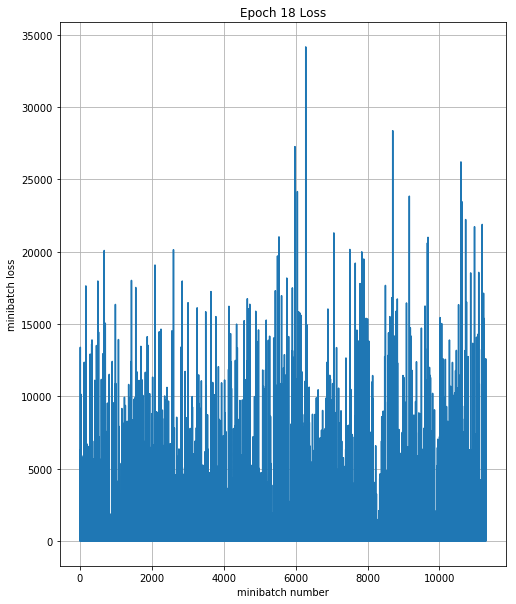

Iteration 203300: with minibatch training loss = 6.58
Iteration 203400: with minibatch training loss = 76.3
Iteration 203500: with minibatch training loss = 0.636
Iteration 203600: with minibatch training loss = 1.13
Iteration 203700: with minibatch training loss = 0.33
Iteration 203800: with minibatch training loss = 0.691
Iteration 203900: with minibatch training loss = 0.821
Iteration 204000: with minibatch training loss = 0.262
Iteration 204100: with minibatch training loss = 29.1
Iteration 204200: with minibatch training loss = 0.266
Iteration 204300: with minibatch training loss = 0.146
Iteration 204400: with minibatch training loss = 0.0402
Iteration 204500: with minibatch training loss = 0.627
Iteration 204600: with minibatch training loss = 0.0914
Iteration 204700: with minibatch training loss = 15.4
Iteration 204800: with minibatch training loss = 65.4
Iteration 204900: with minibatch training loss = 0.958
Iteration 205000: with minibatch training loss = 0.291
Iteration 20510

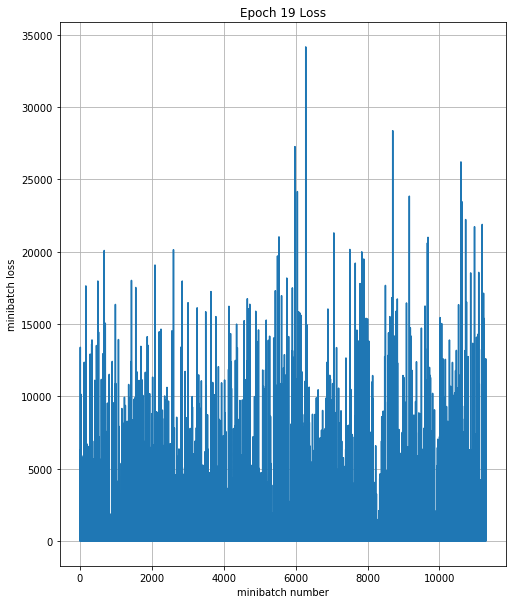

Iteration 214600: with minibatch training loss = 0.104
Iteration 214700: with minibatch training loss = 21.7
Iteration 214800: with minibatch training loss = 0.436
Iteration 214900: with minibatch training loss = 0.745
Iteration 215000: with minibatch training loss = 0.115
Iteration 215100: with minibatch training loss = 0.24
Iteration 215200: with minibatch training loss = 23.7
Iteration 215300: with minibatch training loss = 118
Iteration 215400: with minibatch training loss = 0.531
Iteration 215500: with minibatch training loss = 0.153
Iteration 215600: with minibatch training loss = 8.98
Iteration 215700: with minibatch training loss = 0.676
Iteration 215800: with minibatch training loss = 0.343
Iteration 215900: with minibatch training loss = 19.1
Iteration 216000: with minibatch training loss = 61.9
Iteration 216100: with minibatch training loss = 0.0929
Iteration 216200: with minibatch training loss = 0.0402
Iteration 216300: with minibatch training loss = 5.79
Iteration 216400:

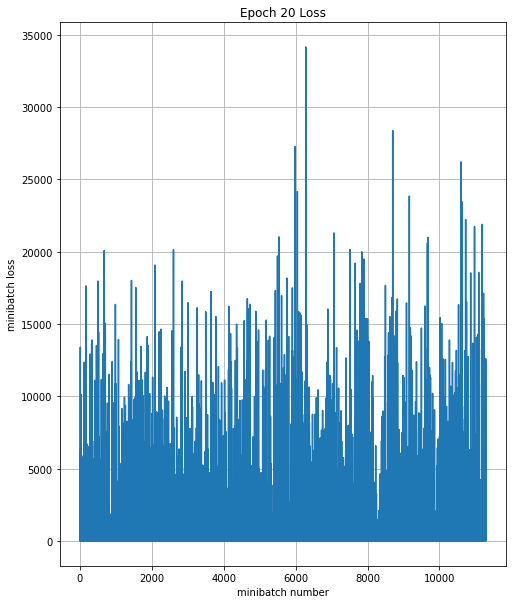

Validation
0.2858253075308905
0.41128083533394877
21.26589404726725
0.26914787925245964
0.42256885526076315
1.3858080424448769
0.49367546266437823
0.8404141911510659
0.3917859426190627
10.859004650438534
2.719625838481654
28.406207627027868
61.27531331370244
0.2875651302016683
19.36969593969839
4.545568859488661
1.696346323333928
0.7974816013435705
0.8966152476065982
1849
Epoch 1, Overall loss = 15.1


In [24]:
pylab.rcParams['figure.figsize'] = (8, 10)
def run_model(session, predict, loss_val, Xd, yd,
              epochs=2, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, predict]
    if training_now:
        variables[-1] = training
    # counter 
    iter_cnt = 0
    predictedYs = []
    for e in range(epochs):
        # keep track of losses and accuracy
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, yOut = session.run(variables,feed_dict=feed_dict)
            predictedYs.append(yOut)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g}"\
                      .format(iter_cnt,loss))
            elif (iter_cnt % print_every) == 0:
                print(np.mean((yOut - yd[idx])**2))
            iter_cnt += 1
        print(len(losses))
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {1}, Overall loss = {0:.3g}"\
              .format(total_loss,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss, predictedYs

with tf.Session() as sess:
    with tf.device("/cpu:0"):
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train, epochs=5, batch_size=64, print_every=100, \
                  training=train_step,plot_losses=True)
        print('Validation')
        total_loss, predictedYs = run_model(sess,y_out, mean_loss, X_val, y_val, 1, 64)

In [25]:
predictedYsArray = np.append(np.array(predictedYs[:-1]).reshape(-1), predictedYs[-1] )
print(predictedYsArray.shape)
print(totalSize - trainSize)

(118336,)
118336


chromosome 5 and chromosome 5
Number of rows and columns: 1, 3


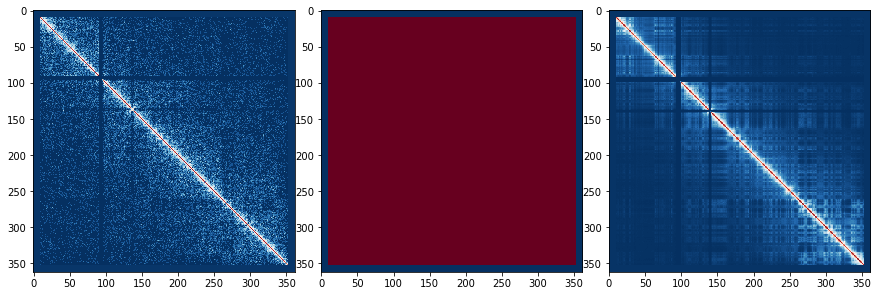

In [26]:
pylab.rcParams['figure.figsize'] = (15, 20)
reconstructed1 = reconstructFromPredictions(X_val, predictedYsArray, cache, beg=trainSize, end=totalSize)
reconstructed2 = reconstructFromPredictions(X_val, y_orig[trainSize:totalSize], cache, beg=trainSize, end=totalSize)
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        images1 = reconstructed1.get((chr1, chr2), None)
        images2 = reconstructed2.get((chr1, chr2), None)
        if images1 == None:
            continue
        print("chromosome %d and chromosome %d"%(chr1, chr2))
        images = [images1[0], images1[1], images2[1]]
        showImages(images)

In [14]:
print(np.mean((predictedYsArray - y_orig[trainSize:totalSize])**2))
print(np.mean((y_val - y_orig[trainSize:totalSize])**2))
print(len(predictedYs))
print(y_val[2], y_orig[trainSize:totalSize][2])

21.272600078422087
0.0
1849
3.8705424792251377 3.8705424792251377


In [2]:
a = tf.sparse_placeholder(tf.float64)
b = tf.placeholder(tf.float64)

ao = scipy.sparse.rand(3, 10000, density=.4)
tf_ao = tf.SparseTensorValue(
    indices=np.array([ao.row, ao.col]).T,
    values=ao.data,
    dense_shape=ao.shape)
bo = np.random.rand(10000, 5)

c = tf.sparse_tensor_dense_matmul(a, b)

feed_dict = {a: tf_ao, b: bo}

with tf.Session() as sess:
    with tf.device("/cpu:0"):
        out = sess.run(c, feed_dict=feed_dict)
        print("\n")
        print(ao.dot(bo))

print(out)



[[ 987.06790687  972.15904415  988.38238443  981.06707546 1008.42496127]
 [ 991.28383759 1017.48437671 1006.60917523 1006.88259052 1026.94421663]
 [ 984.95881262  976.47707223  999.29465081  986.75494814 1023.28645221]]
[[ 987.06790687  972.15904415  988.38238443  981.06707546 1008.42496127]
 [ 991.28383759 1017.48437671 1006.60917523 1006.88259052 1026.94421663]
 [ 984.95881262  976.47707223  999.29465081  986.75494814 1023.28645221]]


Number of rows and columns: 1, 2


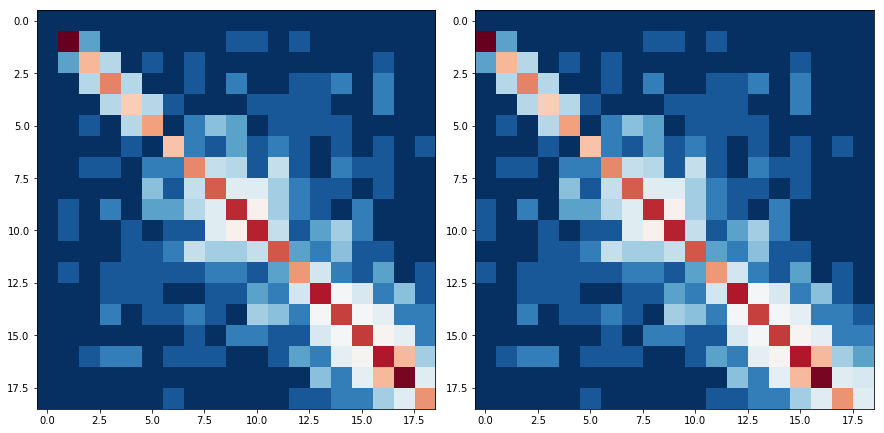

66.60003484412479 32.26668874652544


In [17]:
images = [X_orig[0, :, :, 0]
         , X_orig[1, :, :, 0]]
showImages(images)
print(y_orig[0], X_orig[0, 11, 11, 0])

In [129]:
tf.reset_default_graph()
X = tf.get_variable('X', shape=[1])
#y = tf.squared_difference(X, 5 )
y = tf.pow(X - 5, 2)
optimizer = tf.train.AdamOptimizer(5e-1)
train_step = optimizer.minimize(y)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    variables = [y, X, train_step]
    for i in range(1000):
        yr, Xr, _= sess.run(variables)
    print(Xr, yr, (Xr-1)**2)

[5.] [0.] [16.]


In [12]:
predictedYsArray2 = np.array(predictedYs[:-1])
print(predictedYsArray2.shape)
predictedYsArray2[10, 2, 0] - predictedYs[50][2, 0]

(1848, 64)


IndexError: too many indices for array